# Forecasting Electricity Demand

## Motivation

On $3^{rd}$ April 2020, as Indians were entering the 3rd week of the first covid-19 lockdown, PM Narendra Modi took to social media and twitter asking citizens to switch of their lights and light diyas for 9 minutes at 9pm on $5^{th}$ April 2020, in order to show solidarity with the healthcare and the frontline workers. This was reiterated by hundreds of thousands of prominent persons and celebrities. A major proportion of the citizens of the country of 138 crore population were expected to be a part of it. This led to the fear of a major power grid faliure due to sudden drop and surge in demand. As a result the states had to scramble for preparation of the event, issuing detailed orders to prevent disruptions.

The above case is an example of how important it is to anticipate potential surges and drop in electricity consumption. A power faliure affects not only the production process and industries but also hospitals and other essential functions. Forecasting the demand for electricity is important in order to build enough capacity and prevent power faliures. This is because storing electricity is still expensive and thus it has to be generated as per demand. This forecasting can be in long run, short run or over a medium run period. I use ARMA model on yearly data from UK's electricity board for prediction of total electricity demanded. This analysis can be further extended to include other variables such as the price of electricity, production of the country, availability of fuel, and other social and demand related variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%matplotlib notebook

In [2]:
path = r"C:\Users\parik\Documents\Data sets\Time series course\sac_elect.csv"
df = pd.read_csv(path,index_col=0)
df.head()

,Electricity supplied(net),Purchases from other producers,Net imports,Electricity Available,Losses in transmission,Total loss,Fuel industries,Industrial,Domestic,Other,Total
Year,,,,,,,,,,,
1920,3.976,0.089,0.0,4.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1921,3.605,0.059,0.0,3.664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1922,4.226,0.150,0.0,4.376,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1923,4.928,0.249,0.0,5.177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1924,5.627,0.272,0.0,5.899,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preliminary Analysis

### We try to model the total electricity demand since 1970

<IPython.core.display.Javascript object>


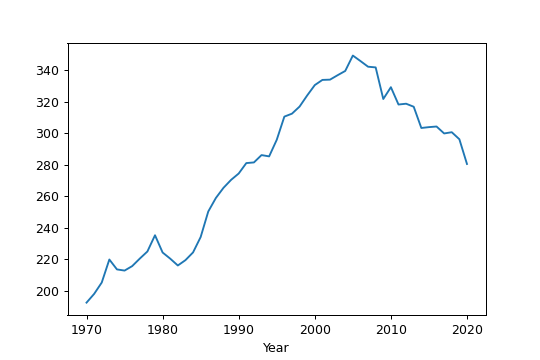

In [3]:
exog = df['Total'][50:].plot()

Taking first difference, we get

<IPython.core.display.Javascript object>


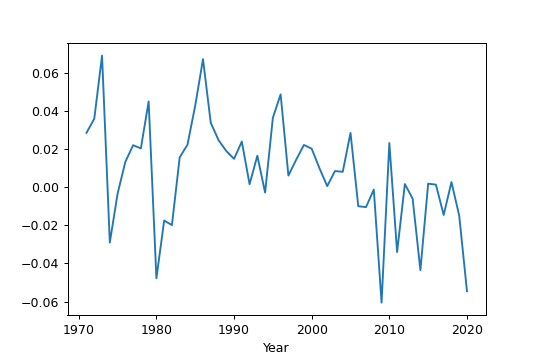

<AxesSubplot:xlabel='Year'>

In [4]:
plt.figure()
exog = np.log(df['Total'][50:]).diff(1)[1:]
exog.plot()

<IPython.core.display.Javascript object>


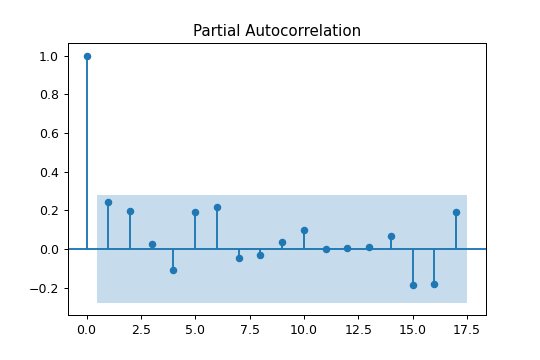

<IPython.core.display.Javascript object>


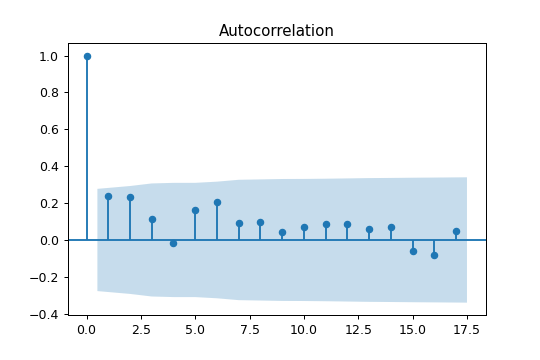

In [5]:
plot_pacf(exog);
plot_acf(exog);

In [6]:
ad_fuller_result = adfuller(exog)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.047705456295545
p-value: 0.030673152466244902


In [7]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### Choose model based on minimum aic criterion

In [8]:
ps = range(0, 8, 1)
d = 0
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=exog)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(0, 1, 1)",-212.425822
1,"(1, 1, 1)",-210.549779
2,"(0, 1, 2)",-210.524329
3,"(0, 1, 3)",-209.593890
4,"(2, 1, 1)",-209.009841
...,...,...
59,"(6, 1, 7)",-196.241582
60,"(6, 1, 6)",-195.477270
61,"(7, 1, 6)",-194.842559
62,"(7, 1, 7)",-193.223241


We model MA(1) and ARMA(1,1)

## Estimating MA(1)

In [9]:
ma_1 = ARIMA(exog, order=(0,1,1)).fit()
print(ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 108.213
Date:                Thu, 24 Feb 2022   AIC                           -212.426
Time:                        15:03:56   BIC                           -208.642
Sample:                             0   HQIC                          -210.990
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8111      0.105     -7.732      0.000      -1.017      -0.605
sigma2         0.0007      0.000      5.969      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

## Estimating ARMA(1,1)

In [10]:
arma_11 = ARIMA(exog, order=(1,1,1)).fit()
print(arma_11.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   50
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 108.275
Date:                Thu, 24 Feb 2022   AIC                           -210.550
Time:                        15:03:56   BIC                           -204.874
Sample:                             0   HQIC                          -208.397
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0619      0.187      0.331      0.741      -0.305       0.429
ma.L1         -0.8316      0.133     -6.274      0.000      -1.091      -0.572
sigma2         0.0007      0.000      5.586      0.0

Going further we can see that we can further improve the model by incorporating breaks.